In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import seaborn as sns
from scipy import stats
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
sns.set()

In [2]:
#Build NA covid data for all airport comparisons
# Build total + new NA cases
NaData = pd.read_csv("Archived-Data/casesNA.csv", compression = 'gzip')
NaData["Date"] = pd.to_datetime(NaData["Date"])
NaSums = NaData.groupby(NaData['Date']).sum().reset_index()
naCases = NaSums[['Date','Confirmed']]
temp = naCases.shift(1)
naCases['New'] = naCases['Confirmed'] - temp['Confirmed']
naCases.loc[0,"New"] = 0
new_cases_smooth = lowess(naCases['New'], naCases["Date"], frac =0.05)
confirm_smooth = lowess(naCases['Confirmed'], naCases["Date"], frac =0.05)
naCases['New_smooth'] = new_cases_smooth[:,1]
naCases['Confirm_smooth'] = confirm_smooth[:,1]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [3]:
yul = pd.read_csv('Airport-Data/yul4analyze_both.csv',index_col =0, parse_dates = [1])
yulCases = pd.read_csv('Covid-Data/yul-modified.csv', index_col =0, parse_dates = [5])

yul["Date"] = pd.to_datetime(yul["Date"])
yulCases["Date"] = pd.to_datetime(yulCases["Date"])

yulCases.loc[0, "Difference"] = 0

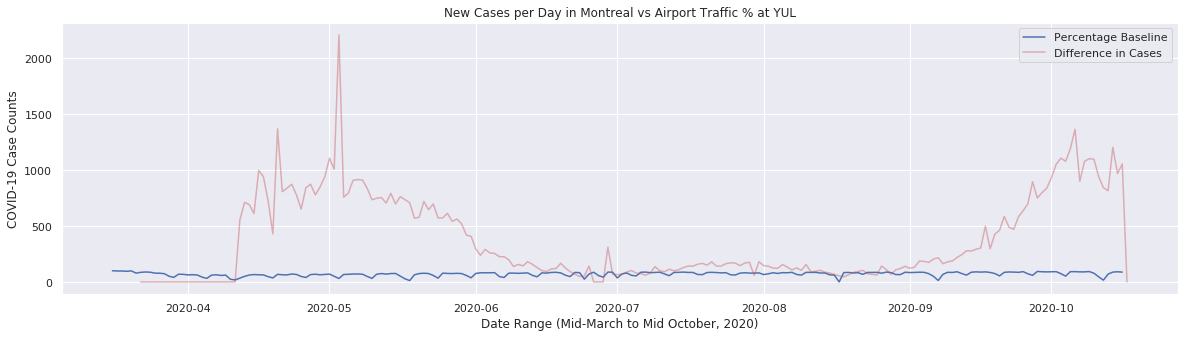

In [5]:
plt.figure(figsize = (20,5))
plt.plot(yul["Date"], yul['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yulCases["Date"], yulCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yulCases["Date"], yulCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Date Range (Mid-March to Mid October, 2020)")
plt.ylabel("COVID-19 Case Counts")
plt.title("New Cases per Day in Montreal vs Airport Traffic % at YUL")
plt.legend()
#plt.savefig('graphs/png/YUL/YUL.png', bbox_inches='tight', dpi = 150)

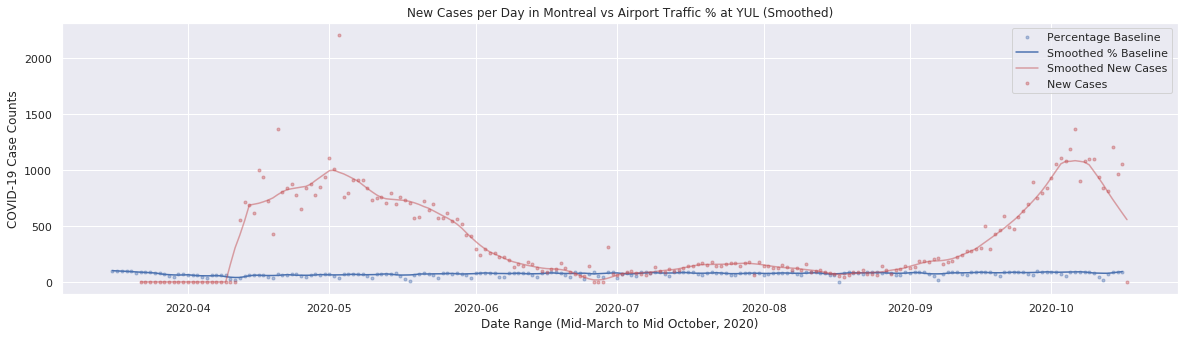

In [6]:
# baseline seems constant; except for the small dip in March
# Find factors to attribute to the two curves - small bump in the summer?
# The second one might be an instance to not increase flights to YUL
# lots of 0s in the beginning.... averaging or imputing the missing values might have been a good idea

new_cases_smooth = lowess(yulCases['Difference'], yulCases["timestamp"], frac =0.05)#,is_sorted = True, return_sorted=False)
baseline_smooth = lowess(yul['PercentOfBaseline'], yul["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
yulCases['Diff_smooth'] = new_cases_smooth[:,1]
yul['Baseline_smooth'] = baseline_smooth[:,1]
# Ensure both yul and yulCases start and end on the same dates
if (yul.count().loc['Date'] != yulCases.count().loc['Date']):
    joined = yulCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yul[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yulCases["Diff_smooth"]
    y = yul["Baseline_smooth"]

plt.figure(figsize = (20,5))
plt.plot(yul["Date"], yul['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yul["Date"], yul['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yulCases["Date"], yulCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yulCases["Date"], yulCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Date Range (Mid-March to Mid October, 2020)")
plt.ylabel("COVID-19 Case Counts")
plt.title("New Cases per Day in Montreal vs Airport Traffic % at YUL (Smoothed)")
plt.legend()
#plt.savefig('graphs/png/YUL/YULFiltered.png', bbox_inches='tight', dpi = 150)

-0.10402831009506958


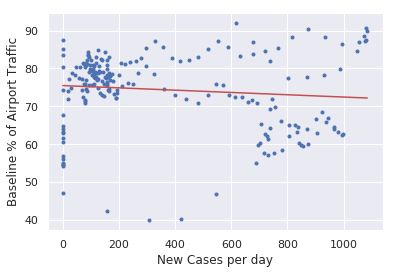

In [7]:
# Find statistical correlation between the two values- Baseline, and New Cases, using the filtered data from above

plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)

print(regression.rvalue)

linearX = np.linspace(0, max(X)) 
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')
#plt.savefig('graphs/png/YUL/YULCorr1.png', bbox_inches='tight', dpi = 150)
# neglible correlation. so assume none at all - look into possible factors
# are people still travelling, or not travelling?

0.7736308232381549


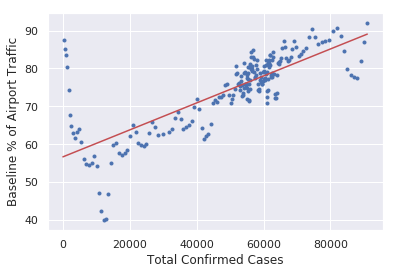

In [8]:
# Repeat for Number of Confirmed Patients
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04)
# to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

reg = stats.linregress(confirmX, y)

print(reg.rvalue)

linearX = np.linspace(0, max(confirmX)) 
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')
#plt.savefig('graphs/png/YUL/YULCorr2.png', bbox_inches='tight', dpi = 150)

In [9]:
X = np.stack([confirmX], axis =1)
X_train,X_valid,y_train,y_valid = train_test_split(X,y)

0.7479118951025064
0.756893751526028


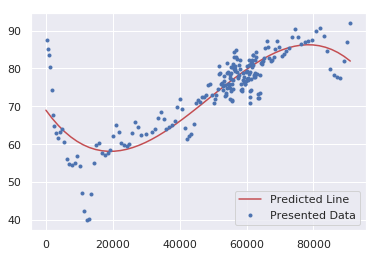

In [10]:
# Poly Regress - looks better than the one from above!
model = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=True),
    LinearRegression(fit_intercept=False)
)

model.fit(X_train, y_train)

linearX = np.linspace(0,max(X_train)).reshape(-1, 1) #maybe change params
plt.plot(linearX, model.predict(linearX), 'r-', label = "Predicted Line")
plt.plot(X, y, 'b.', label = 'Presented Data')
plt.legend()

print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))
#plt.savefig('graphs/png/YUL/YULCorr3.png', bbox_inches='tight', dpi = 150)

0.527173646469731
0.8419890437862961
-0.8346080940000259


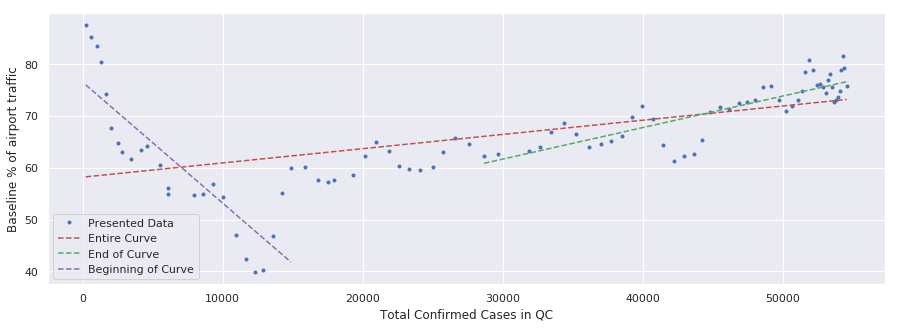

In [11]:
# Analyzing statistical correlation in --> Wave 1 (Apr - June)
first_wave = joined[joined['Date']<'2020-06-20']

plt.figure(figsize = (15,5))

"""plt.plot(first_wave["Date"], first_wave['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.7)
plt.plot(first_wave["Date"], first_wave['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(first_wave["Date"], first_wave["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(first_wave["Date"], first_wave['Difference'], 'r.', label = 'New Cases', alpha = 0.7)
plt.xlabel("Mid-March to Mid-May: First Wave")
plt.legend()
plt.show() #two things over time"""

plt.plot(first_wave["Confirmed"],first_wave["Baseline_smooth"], 'b.', label = 'Presented Data')
plt.xlabel("Total Confirmed Cases in QC")
plt.ylabel("Baseline % of airport traffic")

# Entire Curve
regression = stats.linregress(first_wave["Confirmed"], first_wave["Baseline_smooth"])
print(regression.rvalue)
# Moderate correlation
linearX = np.linspace(min(first_wave["Confirmed"]), max(first_wave["Confirmed"]))
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r--', label = 'Entire Curve')

# Analyze the tail of the first wave: May to mid June
reg2 = stats.linregress(first_wave["Confirmed"].tail(50), first_wave["Baseline_smooth"].tail(50))
print(reg2.rvalue)
# Strong correlation
lin2 = np.linspace(min(first_wave["Confirmed"].tail(50)), max(first_wave["Confirmed"].tail(50)))
plt.plot(lin2, reg2.slope*lin2+ reg2.intercept,'g--', label = 'End of Curve')

# Analyze the steep climb during the rise (1 month):
reg3 = stats.linregress(first_wave["Confirmed"].head(25), first_wave["Baseline_smooth"].head(25))
print(reg3.rvalue)
# Moderate correlation
lin3 = np.linspace(min(first_wave["Confirmed"].head(25)), max(first_wave["Confirmed"].head(25)))
plt.plot(lin3, reg3.slope*lin3+ reg3.intercept,'m--', label = 'Beginning of Curve')
plt.legend()
#plt.savefig('graphs/png/YUL/YULWave1.png', bbox_inches='tight', dpi = 150)

0.3141405402860613
-0.4834189538958141
0.6082750930430638


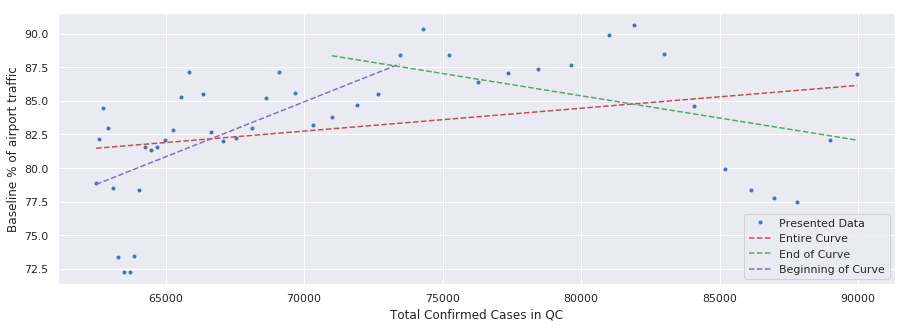

In [12]:
# Wave 2: Sept - Oct (Ongoing)
sec_wave = joined[joined['Date']<'2020-10-16']
sec_wave = sec_wave[sec_wave['Date']>'2020-08-30']

plt.figure(figsize = (15,5))

"""plt.plot(sec_wave["Date"], sec_wave['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.7)
plt.plot(sec_wave["Date"], sec_wave['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(sec_wave["Date"], sec_wave["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(sec_wave["Date"], sec_wave['Difference'], 'r.', label = 'New Cases', alpha = 0.7)
plt.xlabel("Mid-March to Mid-May: sec Wave")
plt.legend()
plt.show() #two things over time"""

plt.plot(sec_wave["Confirmed"],sec_wave["Baseline_smooth"], 'b.', label = 'Presented Data')
plt.xlabel("Total Confirmed Cases in QC")
plt.ylabel("Baseline % of airport traffic")

# Entire Curve
regression = stats.linregress(sec_wave["Confirmed"], sec_wave["Baseline_smooth"])
print(regression.rvalue)
# No correlation
linearX = np.linspace(min(sec_wave["Confirmed"]), max(sec_wave["Confirmed"]))
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r--', label = 'Entire Curve')

# Analyze the tail of the 2nd wave: 
reg2 = stats.linregress(sec_wave["Confirmed"].tail(20), sec_wave["Baseline_smooth"].tail(20))
print(reg2.rvalue)
# Weak correlation
lin2 = np.linspace(min(sec_wave["Confirmed"].tail(20)), max(sec_wave["Confirmed"].tail(20)))
plt.plot(lin2, reg2.slope*lin2+ reg2.intercept,'g--', label = 'End of Curve')

# Analyze the climb (1 month):
reg3 = stats.linregress(sec_wave["Confirmed"].head(30), sec_wave["Baseline_smooth"].head(30))
print(reg3.rvalue)
# Weak correlation
lin3 = np.linspace(min(sec_wave["Confirmed"].head(30)), max(sec_wave["Confirmed"].head(30)))
plt.plot(lin3, reg3.slope*lin3+ reg3.intercept,'m--', label = 'Beginning of Curve')
plt.legend()
#plt.savefig('graphs/png/YUL/YULWave2.png', bbox_inches='tight', dpi = 150)
# This is kind of funky - what happened here?
# Did people decide not to travel or something? 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


0.8780680296352774
0.894597638488924


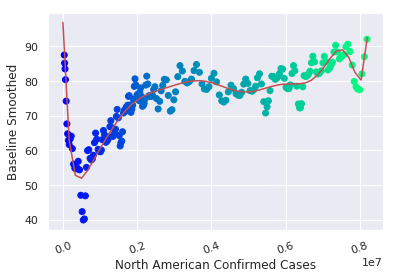

In [13]:
# This is to make sure both yul and naCases start and end on the same dates
if (yul.count().loc['Date'] != naCases.count().loc['Date']):
    na = naCases[["Date","Confirmed","New"]].join(yul[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    na = na.dropna()
    
plt.scatter(na['Confirmed'],na['Baseline_smooth'],c=na['Date'],cmap='winter' )
plt.xlabel("North American Confirmed Cases")
plt.xticks(rotation=20)
plt.ylabel("Baseline Smoothed")

X = np.stack([na['Confirmed']], axis =1)
X_train,X_valid,y_train,y_valid = train_test_split(X,np.stack([na['Baseline_smooth']], axis =1))

poly_regress = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=14, include_bias = True),
    LinearRegression(fit_intercept = False))
poly_regress.fit(X_train, y_train)

linearX = np.stack([np.linspace(0,8200000)],axis=1)

plt.plot(linearX, poly_regress.predict(linearX), 'r-')
print(poly_regress.score(X_train,y_train))
print(poly_regress.score(X_valid,y_valid))
#plt.savefig('graphs/png/YUL/YULML.png', bbox_inches='tight', dpi = 150)

In [14]:
# ML with new cases, total cases, na cases: total + new, vs y= Baseline
# naCases --> Confirmed, New, New_smooth, Confirm_smooth
# joined --> Confirmed, Confirmed_smooth, Difference, Diff_smooth, Baseline_smooth, PercentOfBaseline

joined["Confirmed_smooth"] = confirmX
joined
# X --> na_confirm, na_new, ab_confirm, ab_new
X = naCases[["Confirm_smooth", "New_smooth", "Date"]].join(joined[["Confirmed_smooth","Diff_smooth","Date"]].set_index('Date'), on ='Date')
X = X.rename(columns={"Confirm_smooth": "na_confirm", "New_smooth":"na_new", "Confirmed_smooth":"ab_confirm", "Diff_smooth":"ab_new"})
X = X[["na_confirm","na_new","ab_confirm","ab_new"]].dropna()

# y --> joined['Baseline_smooth']
y = joined['Baseline_smooth'].rename(columns={"Baseline_smooth":"yegBaseline"})

In [15]:
# GB regressor does the best out of all of them bc diff factors are weighed differently
# Also not that much data, so neural network doesn't really work
gbmodel = make_pipeline(
    MinMaxScaler(),
    GradientBoostingRegressor(n_estimators=50, max_depth=5)
    )
gbmodel.fit(X_train, y_train)

print(gbmodel.score(X_train,y_train), gbmodel.score(X_valid,y_valid))

0.9919309534561938 0.9562837703623349


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
